In [1]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 2.9 MB/s eta 0:00:00


1.1 Drum cel mai probabil al agentului: [(7, 0), (7, 0), (7, 1), (7, 2), (8, 2)]
1.1 Log-probabilitatea drumului: -11.237665912517004
1.2 Drum cel mai probabil al agentului fără mutarea la stânga: [(7, 0), (7, 0), (7, 1), (7, 2), (8, 2)]
1.2 Log-probabilitatea drumului fără mutarea la stânga: -10.216014664985023


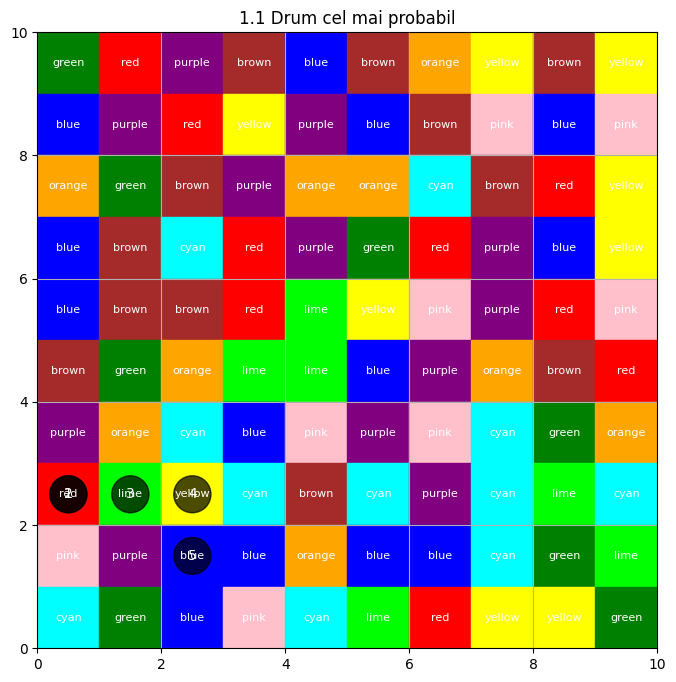

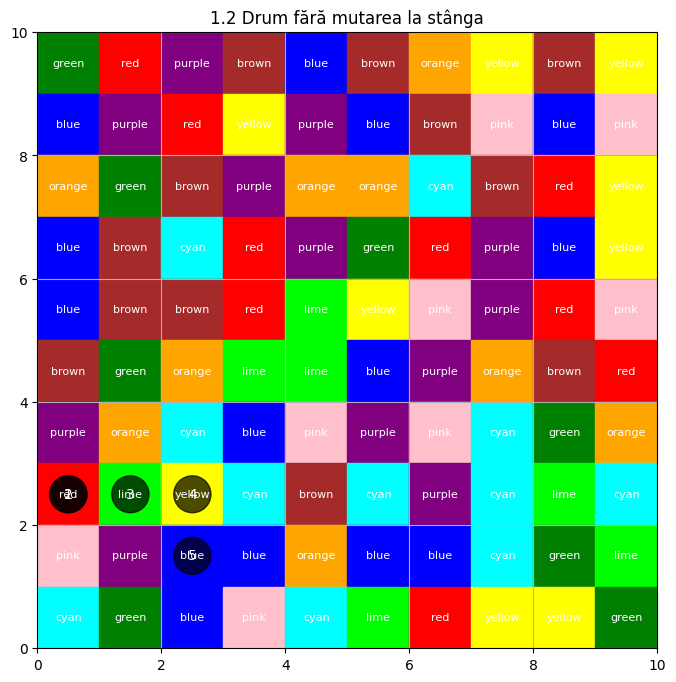

In [16]:
from hmmlearn.hmm import CategoricalHMM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dimensiunea gridului
dimensiune_grid = (10, 10)

# Lista de culori predefinite
culori = [
    "red", "blue", "green", "yellow",
    "purple", "orange", "pink", "cyan",
    "brown", "lime"
]

# Citirea gridului
df = pd.read_csv('grid_culori.csv', header=None)
grid_culori = df.to_numpy()

# Generarea secvenței de culori observate
observatii = ["red", "red", "lime", "yellow", "blue"]

# Mapare culori -> indecși
culoare_to_idx = {culoare: idx for idx, culoare in enumerate(culori)}
idx_to_culoare = {idx: culoare for culoare, idx in culoare_to_idx.items()}

# Transformăm secvența de observații în indecși
observatii_idx = [culoare_to_idx[c] for c in observatii]

# Definim stările ascunse ca fiind toate pozițiile din grid (100 de stări)
numar_stari = dimensiune_grid[0] * dimensiune_grid[1]
stari_ascunse = [(i, j) for i in range(dimensiune_grid[0]) for j in range(dimensiune_grid[1])]
stare_to_idx = {stare: idx for idx, stare in enumerate(stari_ascunse)}
idx_to_stare = {idx: stare for stare, idx in stare_to_idx.items()}

# Matrice de tranziție
transitions = np.zeros((numar_stari, numar_stari))
for i, j in stari_ascunse:
    idx_curent = stare_to_idx[(i, j)]
    vecini = [
        (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1), (i, j)  # sus, jos, stânga, dreapta, loc
    ]
    vecini_valizi = [stare_to_idx[(x, y)] for x, y in vecini if 0 <= x < 10 and 0 <= y < 10]

    for vecin in vecini_valizi:
        if idx_to_stare[vecin] == (i, j - 1):  # Mutare la stânga
            transitions[idx_curent, vecin] = 0.4
        elif idx_to_stare[vecin] == (i, j):  # Rămâne pe loc
            transitions[idx_curent, vecin] = 0.2
        else:  # Restul mutărilor (sus, jos, dreapta)
            transitions[idx_curent, vecin] = 0.4 / 3

# Normalizare matrice tranziție
transitions /= transitions.sum(axis=1, keepdims=True)

# Matrice de emisie
emissions = np.zeros((numar_stari, len(culori)))
for i, j in stari_ascunse:
    idx_curent = stare_to_idx[(i, j)]
    culoare = grid_culori[i, j]
    emissions[idx_curent, culoare_to_idx[culoare]] = 1.0

# Modelul HMM
model = CategoricalHMM(n_components=numar_stari, n_iter=100)

# Probabilități uniforme pentru a permite pornirea din orice poziție
model.startprob_ = np.full(numar_stari, 1 / numar_stari)

# Setăm tranzițiile și emisiile
model.transmat_ = transitions
model.emissionprob_ = emissions

# Rularea algoritmului Viterbi pentru secvența de observații
logprob, secventa_stari_idx = model.decode(np.array([observatii_idx]).T, algorithm="viterbi")
drum = [idx_to_stare[idx] for idx in secventa_stari_idx]

# Afișăm rezultatul pentru 1.1
print("1.1 Drum cel mai probabil al agentului:", drum)
print("1.1 Log-probabilitatea drumului:", logprob)

# Eliminăm posibilitatea ca agentul să ia o mutare la stânga
for i, j in stari_ascunse:
    idx_curent = stare_to_idx[(i, j)]
    if (i, j - 1) in stari_ascunse:  # Mutare la stânga
        transitions[idx_curent, stare_to_idx[(i, j - 1)]] = 0

# Re-normalizare matrice tranziție
transitions /= transitions.sum(axis=1, keepdims=True)

# Actualizare model
model.transmat_ = transitions

# Rulăm algoritmul Viterbi din nou
logprob_no_left, secventa_stari_idx_no_left = model.decode(np.array([observatii_idx]).T, algorithm="viterbi")
drum_no_left = [idx_to_stare[idx] for idx in secventa_stari_idx_no_left]

# Afișăm rezultatul pentru 1.2
print("1.2 Drum cel mai probabil al agentului fără mutarea la stânga:", drum_no_left)
print("1.2 Log-probabilitatea drumului fără mutarea la stânga:", logprob_no_left)

# Vizualizare grid și drumurile
def vizualizare_grid_si_drum(grid, drum, titlu):
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            culoare = grid[i, j]
            ax.add_patch(plt.Rectangle((j, grid.shape[0] - i - 1), 1, 1, color=culoare))
            ax.text(j + 0.5, grid.shape[0] - i - 0.5, culoare,
                    color="white", ha="center", va="center", fontsize=8)

    for idx, (i, j) in enumerate(drum):
        ax.add_patch(plt.Circle((j + 0.5, grid.shape[0] - i - 0.5), 0.3, color="black", alpha=0.7))
        ax.text(j + 0.5, grid.shape[0] - i - 0.5, str(idx + 1),
                color="white", ha="center", va="center", fontsize=10)

    ax.set_xlim(0, grid.shape[1])
    ax.set_ylim(0, grid.shape[0])
    ax.grid(True)
    plt.title(titlu)
    plt.show()

vizualizare_grid_si_drum(grid_culori, drum, "1.1 Drum cel mai probabil")
vizualizare_grid_si_drum(grid_culori, drum_no_left, "1.2 Drum fără mutarea la stânga")

Exercitiul 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# functie pentru a calcula parametrii posteriori
def calcul_beta_posteriori(alpha_prior, beta_prior, succese, esecuri):
    return alpha_prior + succese, beta_prior + esecuri

# functie pentru a reprezenta grafic distributia beta
def grafic_beta(alpha, beta_param, titlu, ax):
    x = np.linspace(0, 1, 1000)
    y = beta.pdf(x, alpha, beta_param)
    ax.plot(x, y, label=f'α={alpha}, β={beta_param}')
    ax.fill_between(x, y, alpha=0.2)
    ax.set_title(titlu)
    ax.set_xlabel('probabilitatea (p)')
    ax.set_ylabel('densitate')
    ax.legend()

# datele pentru experimentul 1
rezultate_1 = ['s', 's', 'b', 'b', 's', 's', 's', 's', 'b', 's']
succese_1 = rezultate_1.count('s')  # numar de succese (s)
esecuri_1 = rezultate_1.count('b')  # numar de esecuri (b)

# parametrii a priori (beta uniforma)
alpha_prior = 1
beta_prior = 1

# calcul parametrii posteriori pentru experimentul 1
alpha_post_1, beta_post_1 = calcul_beta_posteriori(alpha_prior, beta_prior, succese_1, esecuri_1)

# reprezentare grafica pentru cerinta 3.1
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
grafic_beta(alpha_post_1, beta_post_1, "3.1 distributia a posteriori (experiment 1)", ax)
plt.show()

# datele pentru experimentul 2
rezultate_2 = ['b', 'b', 's', 'b', 's', 's', 'b', 's', 's', 'b']
succese_2 = rezultate_2.count('s')
esecuri_2 = rezultate_2.count('b')

# (a) distributie beta uniforma pentru experimentul 2
alpha_post_2a, beta_post_2a = calcul_beta_posteriori(alpha_prior, beta_prior, succese_2, esecuri_2)

# (b) distributie a posteriori obtinuta folosind distributia din 3.1 ca a priori
alpha_post_2b, beta_post_2b = calcul_beta_posteriori(alpha_post_1, beta_post_1, succese_2, esecuri_2)

# reprezentare grafica pentru cerinta 3.2
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
grafic_beta(alpha_post_2a, beta_post_2a, "3.2a distributia a posteriori (beta uniforma)", axs[0])
grafic_beta(alpha_post_2b, beta_post_2b, "3.2b distributia a posteriori (folosind experiment 1)", axs[1])
plt.tight_layout()
plt.show()

# afisam parametrii calculati
print("3.1 parametrii a posteriori (experiment 1):")
print(f"α = {alpha_post_1}, β = {beta_post_1}")
print("3.2a parametrii a posteriori (experiment 2, beta uniforma):")
print(f"α = {alpha_post_2a}, β = {beta_post_2a}")
print("3.2b parametrii a posteriori (experiment 2, folosind experimentul 1):")
print(f"α = {alpha_post_2b}, β = {beta_post_2b}")

: 